In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [21]:

# Tải dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

csv_path = os.path.join(path, "HAM10000_metadata.csv")
data = pd.read_csv(csv_path)

In [29]:
print("Dataset path:", path)
print("\nNội dung trong thư mục:")
for item in os.listdir(path):
    print("-", item)

Dataset path: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2

Nội dung trong thư mục:
- hmnist_28_28_L.csv
- hmnist_8_8_L.csv
- hmnist_28_28_RGB.csv
- HAM10000_images_part_2
- HAM10000_images_part_1
- images
- ham10000_images_part_1
- ham10000_images_part_2
- HAM10000_metadata.csv
- hmnist_8_8_RGB.csv


In [31]:
IMG_DIR_1 = os.path.join(path, "HAM10000_images_part_1")
IMG_DIR_2 = os.path.join(path, "HAM10000_images_part_2")
METADATA = os.path.join(path, "HAM10000_metadata.csv")

In [32]:
df = pd.read_csv(METADATA)
print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [33]:
# Gộp đường dẫn ảnh
df['path'] = df['image_id'].map(lambda x:
    os.path.join(IMG_DIR_1, f"{x}.jpg") if os.path.exists(os.path.join(IMG_DIR_1, f"{x}.jpg"))
    else os.path.join(IMG_DIR_2, f"{x}.jpg")
)

In [36]:

# Loại bỏ các hàng không có ảnh
df = df[df['path'].apply(os.path.exists)]

# Mã hóa nhãn bệnh
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])


In [37]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [38]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='dx',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='dx',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [39]:
# --- Xây dựng mô hình CNN ---
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,439 (12.61 MB)

 Trainable params: 3,305,991 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

# --- Lưu mô hình ---
model.save("skin_cancer_cnn_model.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 564ms/step - accuracy: 0.6060 - loss: 1.3888 - val_accuracy: 0.6311 - val_loss: 1.7224
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 94s 375ms/step - accuracy: 0.6539 - loss: 0.9505 - val_accuracy: 0.7044 - val_loss: 0.9961
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 96s 382ms/step - accuracy: 0.6718 - loss: 0.8887 - val_accuracy: 0.7134 - val_loss: 0.7645
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 99s 394ms/step - accuracy: 0.6931 - loss: 0.8462 - val_accuracy: 0.7254 - val_loss: 0.8071
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 398ms/step - accuracy: 0.6939 - loss: 0.8577 - val_accuracy: 0.7329 - val_loss: 0.7280
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 399ms/step - accuracy: 0.6992 - loss: 0.8048 - val_accuracy: 0.7239 - val_loss: 0.7278
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 398ms/step - accuracy: 0.6933 - loss: 0.8324 - val_accuracy: 0.7294 - val_loss: 0.7217
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 97s 386ms/step - accuracy: 0.6963 - los

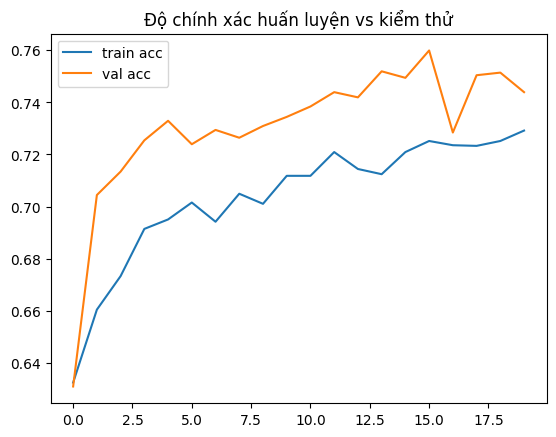

In [41]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Độ chính xác huấn luyện vs kiểm thử")
plt.show()